In [1]:
import time
from torchvision import models
import torch.nn.functional as F
from scipy import linalg

In [2]:
import numpy as np
import torchvision.utils as utils
from IPython.display import HTML

In [3]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
data_folder = "dataset"

In [5]:
print('Downloading data..')
data_raw = datasets.CIFAR10(root=data_folder, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

data_loader = torch.utils.data.DataLoader(data_raw, batch_size=32,
                                         shuffle=True, num_workers=2)

device = torch.device("cuda")

Files already downloaded and verified


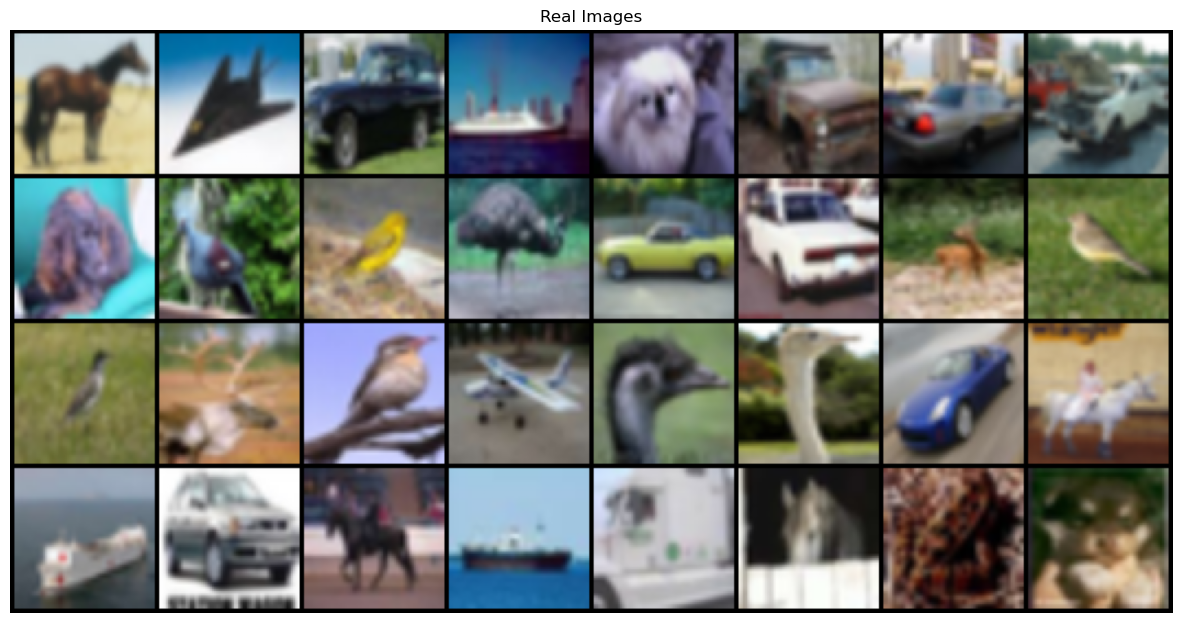

In [7]:
real_image_batch = next(iter(data_loader))
plt.figure(figsize=(15,10))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_image_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

<h3> Define the Generator and Discriminator architecture </h3>

In [8]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [9]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [10]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

<h3> Initialise model weights </h3>

In [12]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,
        192: 1,
        768: 2,
        2048: 3
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

In [13]:
def sqrtm_approx(A, method='ss'):
    if method == 'ss':
        # Scaling and squaring method
        U, s, V = np.linalg.svd(A)
        s = np.diag(np.sqrt(s))
        return U.dot(s).dot(V)
    elif method == 'pi':
        # Power iteration method
        maxiter = 100
        tol = 1e-6
        X = np.eye(A.shape[0])
        for i in range(maxiter):
            Y = 0.5 * (X + A.dot(np.linalg.inv(X)))
            if np.max(np.abs(X - Y)) < tol:
                break
            X = Y
        return X
    else:
        raise ValueError("Invalid method: %s" % method)

In [14]:
def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    covmean = sqrtm_approx(sigma1.dot(sigma2), 'ss')
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = sqrtm_approx((sigma1 + offset).dot(sigma2 + offset), 'ss')

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1 = calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2 = calculate_activation_statistics(images_fake,model,cuda=True)
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

In [15]:
lr = 5e-5
Z_DIM = 128
num_epochs = 50
WEIGHT_CLIP = 0.01

In [16]:
gen = Generator(Z_DIM, channels_img = 3, features_g = 64).to(device)
critic = Discriminator(channels_img = 3, features_d = 64).to(device)
initialize_weights(gen)
initialize_weights(critic)

In [17]:
opt_gen = optim.RMSprop(gen.parameters(), lr = lr)
opt_critic = optim.RMSprop(critic.parameters(), lr = lr)

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
step = 0

gen.train()
critic.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [18]:
generator_loss = []
discriminator_loss = []
fake_images = []
fretchet_distances = []
iters = 0

for epoch in range(num_epochs):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(device)
        cur_batch_size = data.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        for _ in range(5): # 5 critic iterations
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(data).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            # clip critic weights between -0.01, 0.01
            for p in critic.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        #saving the losses for every 100 batch
        generator_loss.append(loss_gen.detach().cpu())
        discriminator_loss.append(loss_critic.detach().cpu())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs) and (batch_idx == len(data_loader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            fake_images.append(utils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
    fretchet_dist = calculate_fretchet(data, fake, model)
    fretchet_distances.append(fretchet_dist)

    if epoch % 5  == 0:
        print(f"Epoch - [{epoch}/{num_epochs}] Batch - {batch_idx}/{len(data_loader)} Discriminator Loss: {loss_critic:.3f}, Generator loss: {loss_gen:.3f}, FID Score: {fretchet_dist:.3f} ")

    utils.save_image(fake.detach(),'Results1/wgan_images/fake/WGAN_epoch_%03d.png' % (epoch), normalize = True)
    
    #Saving Real image/epoch 
    utils.save_image(data.detach(),'Results1/wgan_images/real/WGAN_epoch_%03d.png' % (epoch), normalize = True)


Epoch - [0/50] Batch - 1562/1563 Discriminator Loss: -1.118, Generator loss: 0.578, FID Score: 376.698 
Epoch - [5/50] Batch - 1562/1563 Discriminator Loss: -0.956, Generator loss: 0.569, FID Score: 323.121 
Epoch - [10/50] Batch - 1562/1563 Discriminator Loss: -0.679, Generator loss: 0.178, FID Score: 328.179 
Epoch - [15/50] Batch - 1562/1563 Discriminator Loss: -0.677, Generator loss: 0.074, FID Score: 319.666 
Epoch - [20/50] Batch - 1562/1563 Discriminator Loss: -0.600, Generator loss: 0.165, FID Score: 335.187 
Epoch - [25/50] Batch - 1562/1563 Discriminator Loss: -0.561, Generator loss: -0.057, FID Score: 305.101 
Epoch - [30/50] Batch - 1562/1563 Discriminator Loss: -0.603, Generator loss: 0.313, FID Score: 297.394 
Epoch - [35/50] Batch - 1562/1563 Discriminator Loss: -0.601, Generator loss: 0.113, FID Score: 314.352 
Epoch - [40/50] Batch - 1562/1563 Discriminator Loss: -0.290, Generator loss: 0.095, FID Score: 303.127 
Epoch - [45/50] Batch - 1562/1563 Discriminator Loss: -0

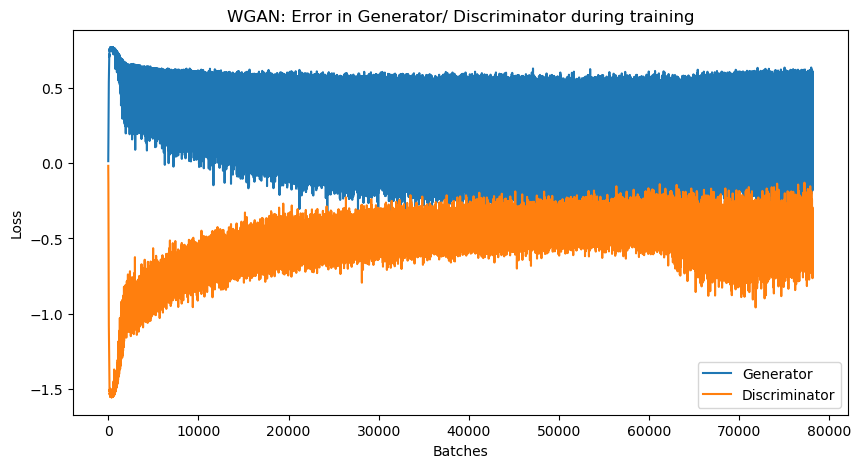

In [19]:
plt.figure(figsize=(10,5))
plt.title("WGAN: Error in Generator/ Discriminator during training")
plt.plot(generator_loss,label="Generator")
plt.plot(discriminator_loss,label="Discriminator")
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.legend()
plt.show()

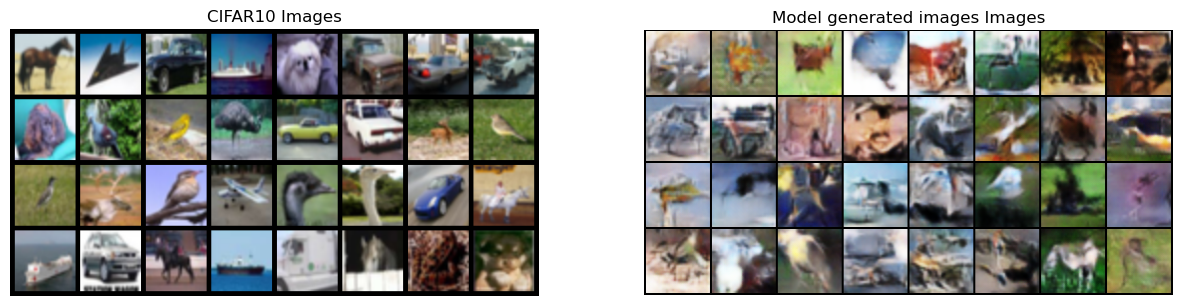

In [21]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("CIFAR10 Images")
plt.imshow(np.transpose(utils.make_grid(real_image_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Model generated images Images")
plt.imshow(np.transpose(fake_images[-1],(1,2,0)))
plt.savefig('Results1/compare.png')
plt.show()

In [24]:
import pickle
with open('Results1/wgan_images/fd_wgan.pickle', 'wb') as f:
    pickle.dump(fretchet_distances, f)

In [26]:
import numpy as np
import pickle

# Load pickle file
with open('Results1/wgan_images/fd_wgan.pickle', 'rb') as f:
    data = pickle.load(f)

# Convert to numpy array
numpy_array = np.array(data)

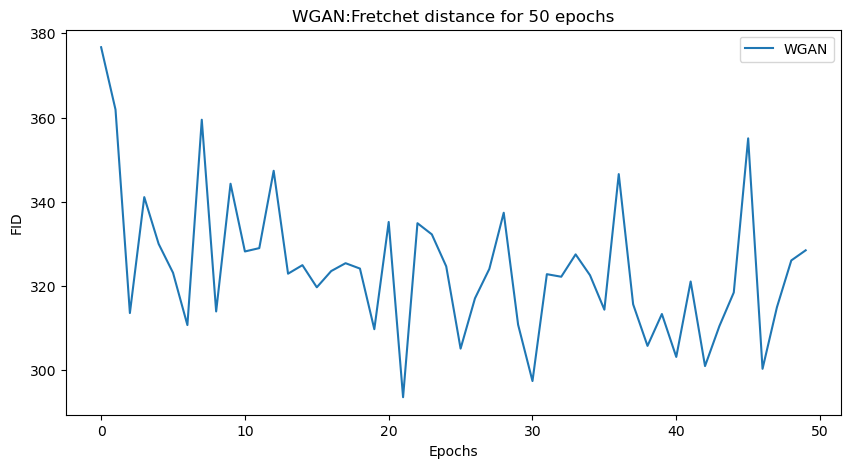

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("WGAN:Fretchet distance for 50 epochs")
plt.plot(numpy_array,label="WGAN")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.show()